In [ ]:
%pip install bertopic

In [ ]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import plotly.express as px
import string

from hdbscan import HDBSCAN
from umap import UMAP
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from bertopic import BERTopic

import matplotlib.pyplot as plt
from collections import defaultdict

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
nltk.download('stopwords')

# Setup e Pre-processing

## Download Dataset

In [8]:
dfs = []

for cls in ["Hate"]:
    for i in range(1, 5):  # files 1 to 4
        file_name = f"{cls}_Speeches_{i}.csv"
        tmp = pd.read_csv(file_name, usecols=["created_at", "full_text"])
        tmp["class"] = cls
        dfs.append(tmp)

# Combine all files into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce", utc=True)

# Drop invalid dates
df = df.dropna(subset=["created_at"]).reset_index(drop=True)

df["date"] = df["created_at"].dt.to_period("D")
texts_list = df["full_text"]

print(f"Total rows combined: {len(df)}")

Total rows combined: 966


In [9]:
# @title Creazione degli Embeddings
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
embeddings = model.encode(texts_list, show_progress_bar=True)

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

## Dimensionality Reduction

In [27]:
from sklearn.decomposition import PCA

# Denoising embedding trough PCA
pca = PCA(n_components=50, random_state=42)
reduced_embeddings = pca.fit_transform(embeddings)

#umap_model = UMAP(n_components=5, min_dist=0.0, metric="cosine", random_state=42)
umap_model = UMAP(
    n_neighbors=30, # Default is 15, maube this could also go up
    n_components=5,  # Same
    metric="cosine",
    min_dist=0.0,
    random_state=42
)

# Topic Modeling con BERTTopic

## Rimozione delle stopwords dagi articoli


In [36]:
# Nel calcoo degli embedding contestuali rimuovere le stopwords non da alcun vantaggio, anzi potrebbe peggiorare le performance.
# Tuttavia BERTTopic utilizza internamente una variante di TF-IDF ragion per cui utilizziamo gli embeddings generati dal testo originale ma passiamo il testo "pulito" al modello
# N.B. Senza questo accorgimento il modello fa molta fatica ed individua solo 2 topics con rappresentati tutte stopword

stop_words = set(stopwords.words("english"))
processed_texts = [None] * texts_list.__len__()

for i in range(texts_list.__len__()):
    # Remove stop words
    processed_texts[i] = " ".join([word for word in word_tokenize(texts_list[i]) if word.lower() not in stop_words and word not in string.punctuation and word.lower() != "hate" and not word.lower().startswith("http")])

## Istanziazione del modello e creazione dei topic

In [37]:
#min_samples should reduce some noise
hdbscan_model = HDBSCAN(min_cluster_size=30, min_samples = 5, metric="euclidean",cluster_selection_method="eom")
topic_model = BERTopic(embedding_model = model, umap_model = umap_model, hdbscan_model = hdbscan_model, verbose=True).fit(processed_texts, reduced_embeddings)

2025-09-25 07:08:15,281 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-25 07:08:19,681 - BERTopic - Dimensionality - Completed ✓
2025-09-25 07:08:19,682 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-25 07:08:19,705 - BERTopic - Cluster - Completed ✓
2025-09-25 07:08:19,709 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-25 07:08:19,746 - BERTopic - Representation - Completed ✓


In [38]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,190,-1_words_speech_co_love,"[words, speech, co, love, twitter, years, thin...",[BREAKING BIDEN 'S STATE UNION MASTERPIECE '' ...
1,0,137,0_comments_co_always_everybody,"[comments, co, always, everybody, report, show...",[‼️MASS REPORT -spreading defamation comments ...
2,1,135,1_speech_co_video_like,"[speech, co, video, like, people, words, murde...",[Cis people really like `` omg bullied day vid...
3,2,113,2_co_hindu_hatespeech_muslims,"[co, hindu, hatespeech, muslims, amp, hinduras...",[Vidyadhar Jaipur Rajasthan Vishwa Hindu Paris...
4,3,72,3_comments_co_like_someone,"[comments, co, like, someone, reading, tweets,...",[movie `` Four Good Days '' Glenn close plays ...
5,4,68,4_anthonny_co_speech_started,"[anthonny, co, speech, started, hatespeech, se...",[Remember didnt start gas chambers started pol...
6,5,58,5_words_worst_much_experience,"[words, worst, much, experience, co, express, ...",[need choose words wisely always tend generali...
7,6,56,6_one_harry_video_buy,"[one, harry, video, buy, genius, comments, gam...",[incase wan na add one block list dropping str...
8,7,53,7_comments_jasmine_rose_white,"[comments, jasmine, rose, white, yvonne, selca...",[hour Suchwita starts Let remind 1 Respect art...
9,8,50,8_somaliland_speech_co_omar,"[somaliland, speech, co, omar, beyond, ministe...",[Islamist radical democrat Ilhan Omar removed ...


## Cluster analysis

In [39]:
topic_model.visualize_topics()

In [40]:
topics_over_time = topic_model.topics_over_time(texts_list, list(df["date"].astype(str)))
topic_model.visualize_topics_over_time(topics_over_time)

12it [00:00, 68.50it/s]


In [41]:
fig = topic_model.visualize_documents(
  texts_list,
  reduced_embeddings = reduced_embeddings,
  width = 1200,
  hide_annotations = False
)
fig.update_layout(font = dict(size = 16))
topic_model.visualize_barchart()

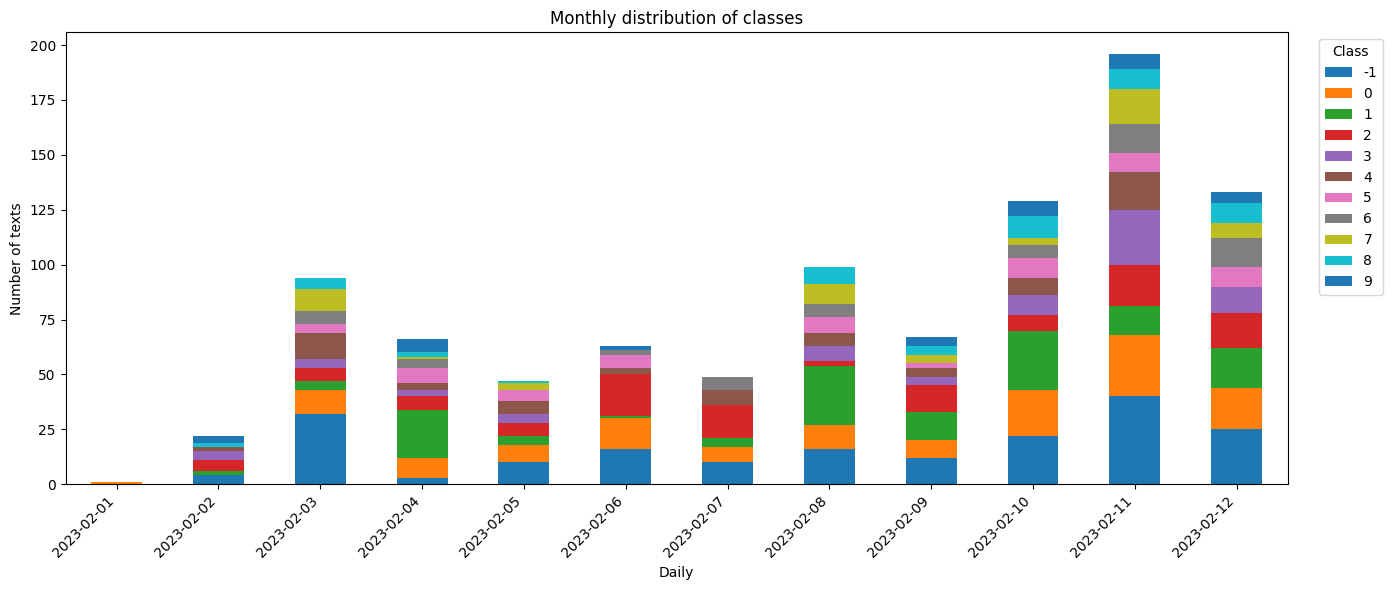

In [42]:
import matplotlib.pyplot as plt

df["topic"] = topic_model.topics_

monthly_counts = df.groupby(["date", "topic"]).size().unstack(fill_value=0).sort_index()
monthly_counts.plot(kind="bar", stacked=True, figsize=(14, 6))

plt.title("Monthly distribution of classes")
plt.xlabel("Daily")
plt.ylabel("Number of texts")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Class", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [43]:
topic_model.visualize_heatmap(n_clusters = 2)